In [1]:
import numpy as np
import pandas as pd
import random
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM


true x0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true f: [0.         0.01123988 0.01207819 0.01155182 0.02688619 0.
 0.01019029 0.         0.         0.        ]
a = 1.8531667261047913, b = 1.5312904682995265


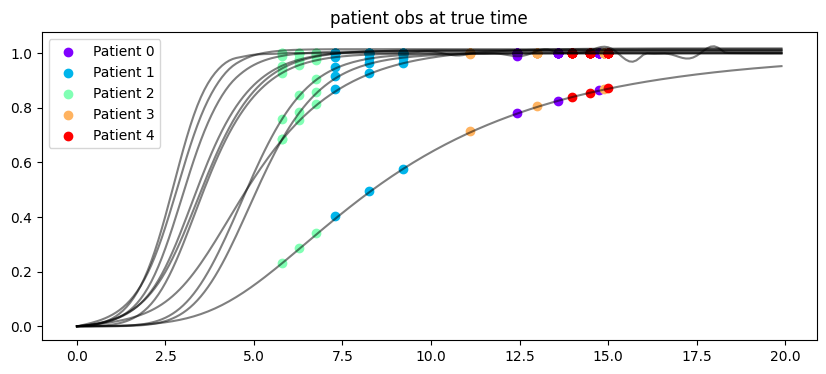

(600, 10) (600,) (600,) (600,) (600,)


In [2]:
# params
n_biomarkers = 10
t_max = 20
t_span = np.linspace(0, t_max, 8000)
noise_level = 0.0
n_patients = 200
n_patient_obs = 3

# fit and transform
t, x_true, K, x0, f, scalar_K  = generate_logistic_model(n_biomarkers=n_biomarkers, t_max=t_max)

df, cog_a, cog_b = generate_synthetic_data(
    n_biomarkers = n_biomarkers,
    t_max = t_max, 
    noise_level = noise_level,
    n_patients = n_patients,
    n_patient_obs = n_patient_obs,
    x_true=x_true, 
    t=t,
)
#plot_biomarker_trajectories(t, x_true, n_biomarkers=n_biomarkers)
plot_true_observations(df, t, x_true)

biomarker_cols = [col for col in df.columns if col.startswith("biomarker_")]

X = df[biomarker_cols].values       # (n_obs, n_biomarkers)
dt = df["dt"].values                # (n_obs,)
ids = df["patient_id"].values       # (n_obs,)
cog = df["cognitive_score"].values  # (n_obs,)
beta_true = df["beta_true"].values 

print(X.shape, dt.shape, ids.shape, cog.shape, beta_true.shape)

In [3]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian=True, lambda_cog=0.0, lamda=0.01)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 1.0
initial beta: (200,)
prepend complete


  0%|          | 0/30 [00:00<?, ?it/s]

  7%|▋         | 2/30 [00:06<01:27,  3.11s/it]

100%|██████████| 30/30 [00:20<00:00,  1.47it/s]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [1.90588881e-01 4.48989053e-04 3.63213914e-03 7.44503864e-03
 1.60092060e-02 1.69833481e-02 1.28301257e-03 4.19872953e-05
 3.77035732e-05 1.30734905e-04]


EM(lambda_cog=0.0, num_iterations=30, rng=Generator(PCG64) at 0x7FEFE7E91C40,
   t_max=20)

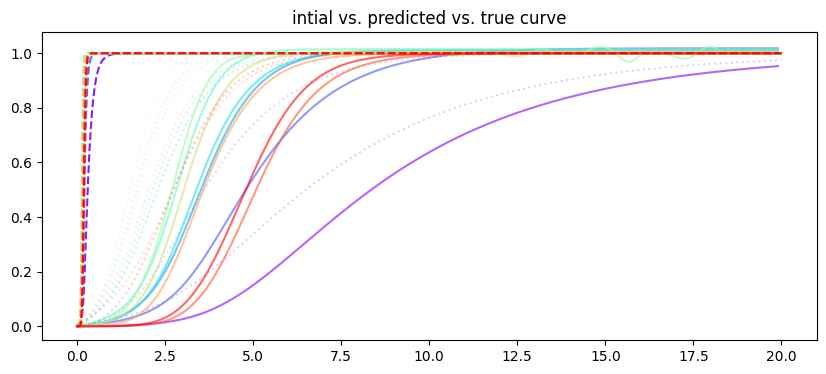

In [4]:
f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
#plot_beta_overlay(df, beta_iter=, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
#plot_beta_error_history(beta_history, em_model_0.num_iterations)
#plot_lse(lse_history)
#plot_cog_regression_history(em_model_0.cog_regression_history_)



In [5]:
print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta true: ",np.round(beta_true,3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.191 0.    0.004 0.007 0.016 0.017 0.001 0.    0.    0.   ]
s:  [0.577 0.851 0.931 0.936 0.963 0.966 0.953 0.923 0.846 0.865]
s_k:  34.202661704644136

BETA SUMMARY:
beta true:  [12.442 12.442 12.442  7.301  7.301  7.301  5.794  5.794  5.794 11.114
 11.114 11.114 13.978 13.978 13.978  6.017  6.017  6.017  0.608  0.608
  0.608  5.207  5.207  5.207  5.763  5.763  5.763  6.512  6.512  6.512
 15.966 15.966 15.966  5.926  5.926  5.926  2.145  2.145  2.145  0.315
  0.315  0.315 12.133 12.133 12.133 17.218 17.218 17.218 10.719 10.719
 10.719 16.757 16.757 16.757 11.055 11.055 11.055  1.898  1.898  1.898
  3.309  3.309  3.309  3.383  3.383  3.383  2.719  2.719  2.719  4.915
  4.915  4.915  9.419  9.419  9.419 16.774 16.774 16.774 10.892 10.892
 10.892  5.143  5.143  5.143 13.208 13.208 13.208  3.251  3.251  3.251
  9.468  9.468  9.468  1.

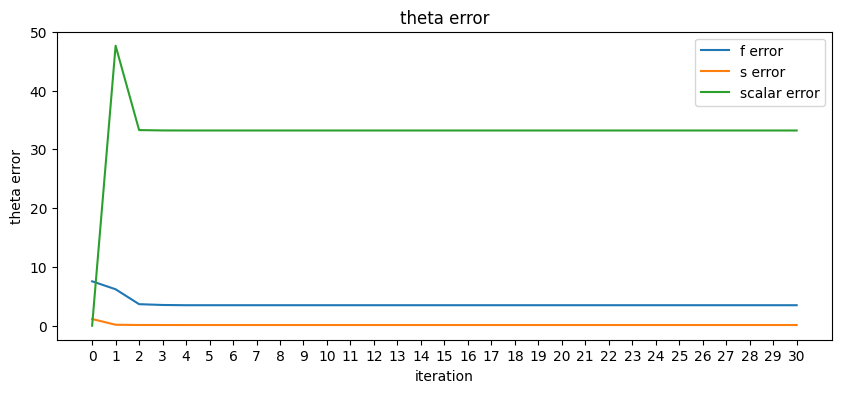

In [6]:
import matplotlib.pyplot as plt

def plot_theta_error_history(theta_history: np.ndarray, n_biomarkers: int,
                             f_true: np.ndarray, s_true: np.ndarray, scalar_K_true: float) -> None:
    """
    Plots normalized error of each parameter group over EM iterations.
    """
    num_iterations = theta_history.shape[1]
    f_error_history = []
    s_error_history = []
    scalar_K_error_history = []

    for iteration in range(num_iterations):
        theta = theta_history[:,iteration]

        f_est = theta[0:n_biomarkers]
        s_est = theta[n_biomarkers:2*n_biomarkers]
        scalar_K_est = theta[-1]

        f_err = np.mean(np.abs(f_true - f_est)) / (np.mean(np.abs(f_true)) + 1e-8)
        s_err = np.mean(np.abs(s_true - s_est)) / (np.mean(np.abs(s_true)) + 1e-8)
        k_err = np.abs(scalar_K_true - scalar_K_est) / (np.abs(scalar_K_true) + 1e-8)

        f_error_history.append(f_err)
        s_error_history.append(s_err)
        scalar_K_error_history.append(k_err)
        
    plt.figure(figsize=(10, 4))
    plt.plot(f_error_history, label="f error")
    plt.plot(s_error_history, label="s error")
    plt.plot(scalar_K_error_history, label="scalar error")
    plt.xticks(range(0,num_iterations))
    plt.title("theta error")
    plt.xlabel("iteration")
    plt.ylabel("theta error")
    plt.legend()
    plt.show()
    
plot_theta_error_history(theta_history=theta_history, n_biomarkers=n_biomarkers,
                         f_true=f, s_true=np.ones(n_biomarkers), scalar_K_true=scalar_K)

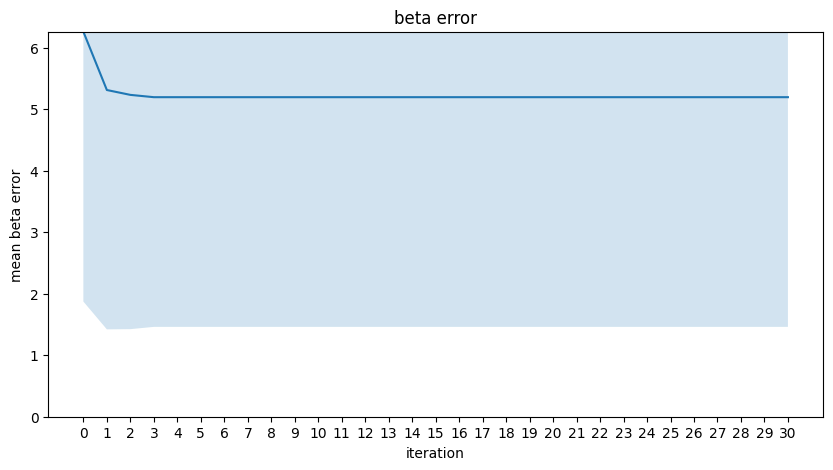

In [7]:
def plot_beta_error_history(beta_history: np.ndarray, beta_true: np.ndarray) -> None:
    """
    Plots mean beta estimation error over EM iterations.
    """
    num_iterations = beta_history.shape[1]
    beta_error_mean_history = np.zeros(num_iterations)
    beta_error_std_history = np.zeros(num_iterations)
    for iteration in range(num_iterations):
        beta_estimated = beta_history[:, iteration]    
        beta_error = np.abs(beta_estimated - beta_true)
        beta_error_mean_history[iteration] = np.mean(beta_error)
        beta_error_std_history[iteration] = np.std(beta_error)

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(beta_error_mean_history)), beta_error_mean_history)
    plt.fill_between(range(len(beta_error_mean_history)),
                     beta_error_mean_history - beta_error_std_history,
                     beta_error_mean_history + beta_error_std_history,
                     alpha = 0.2)
    plt.ylim([0, max(beta_error_mean_history)])
    plt.xticks(range(0,num_iterations))
    plt.xlabel("iteration")
    plt.ylabel("mean beta error")
    plt.title("beta error")
    plt.show()

beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)

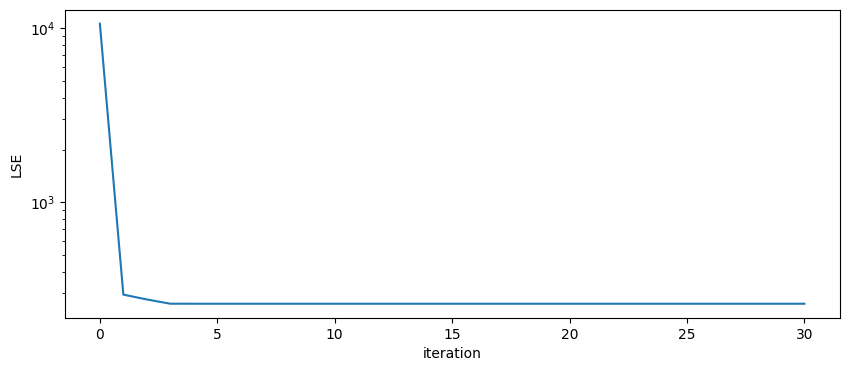

In [8]:
plot_lse(lse_history)

(2, 31)


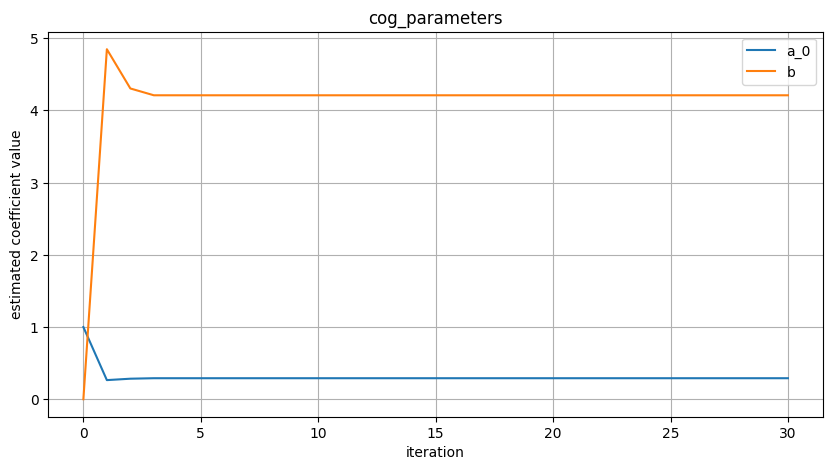

In [9]:
print(em_model_0.cog_regression_history.shape)

cog_true = np.array([cog_a, cog_b])
def plot_cog_regression_history(cog_history: np.ndarray, cog_true: np.ndarray):
    n_params, num_iterations = cog_history.shape
    
    # cog_error = np.zeros_like(cog_history)
    # for i in range(num_iterations):
    #     cog_error[:,i] = cog_error[:,i] - cog_true
    
    plt.figure(figsize=(10, 5))
    for i in range(n_params):
        label = f"a_{i}" if i < n_params - 1 else "b"
        plt.plot(range(num_iterations), cog_history[i,:], label=label)
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("estimated coefficient value")
    plt.title("cog_parameters")
    plt.grid(True)
    plt.show()
    
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)